In [1]:
from vc_clothes_dataset import VCClothesDataset, build_transforms
from face_dataset import FaceDataset
from face_detector import FaceDetector
from face_feature_extractor import FaceFeatureExtractor
from face_feature_extractor_wrapper import FaceReIDTrainWrapper
from trainer import Trainer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_ROOT = "./data/vc_clothes"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
LR = 0.00035
EPOCHS = 3

In [3]:
# Tworzenie transformacji
train_transforms = build_transforms(is_train=True)
val_transforms = build_transforms(is_train=False)

# Instancja datasetu treningowego
# VC-Clothes ma 9,449 obrazów treningowych [cite: 194]
train_set = VCClothesDataset(DATA_ROOT, mode="train", transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)

# Instancja datasetu testowego (Query)
# VC-Clothes ma 1,020 obrazów query [cite: 194]
query_set = VCClothesDataset(DATA_ROOT, mode="query", transform=val_transforms)
test_loader = DataLoader(query_set, batch_size=32, shuffle=False, num_workers=4)

print("\nPrzykładowy element batcha:")
imgs, pids, cams, clothes = next(iter(train_loader))
print(f"Shape obrazów: {imgs.shape}")  # Oczekiwane [32, 3, 256, 128]
print(f"PIDs: {pids}")
print(f"Clothes IDs: {clothes}")

Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3

Przykładowy element batcha:
Shape obrazów: torch.Size([32, 3, 256, 128])
PIDs: tensor([195,  52, 126, 178, 208, 134,   9, 149, 182,  90,  84, 154, 185,   0,
         22, 225, 133, 128,  43, 106, 224, 243,  33, 233,  67, 212, 204,  54,
        161, 251,  83,  10])
Clothes IDs: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
        3, 2, 1, 3, 2, 1, 2, 1])


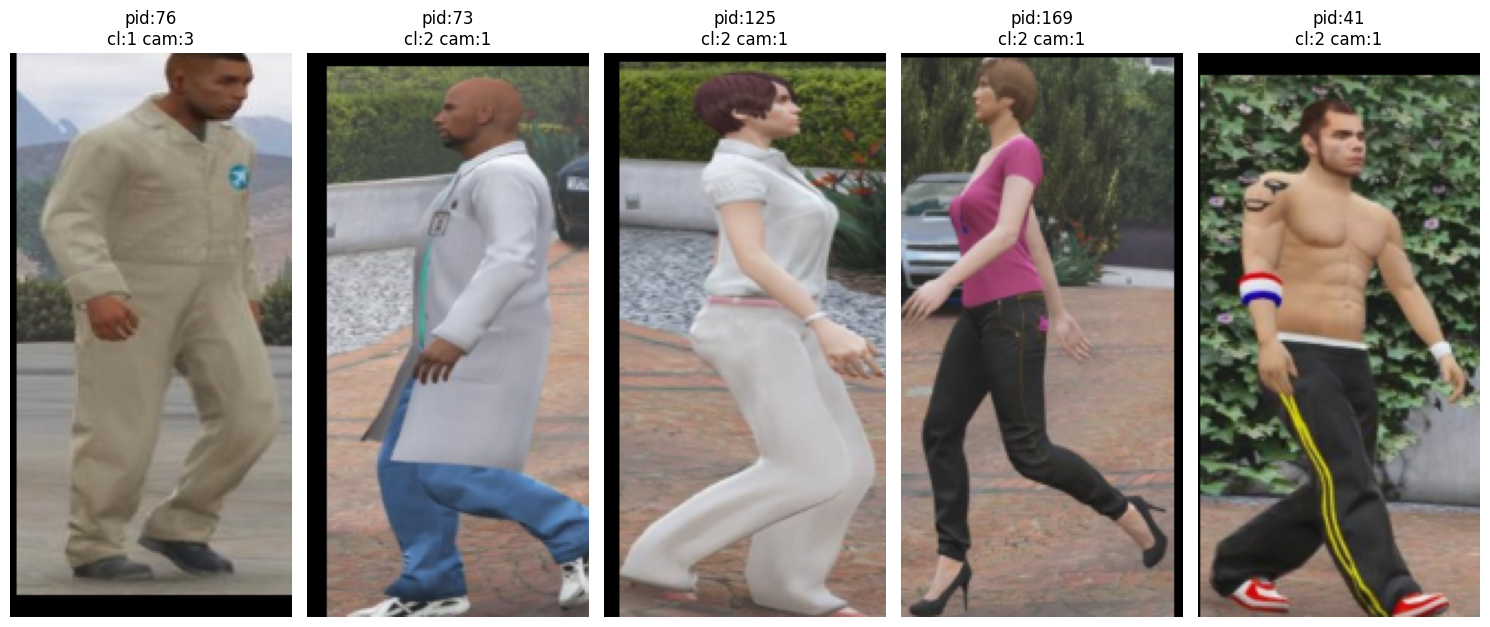

In [4]:
imgs_batch, pids_batch, cams_batch, clothes_batch = next(iter(train_loader))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def unnormalize(tensor_img):
    # tensor_img: torch.Tensor C,H,W
    img = tensor_img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # H,W,C
    img = (img * std) + mean  # odwrócenie normalizacji
    img = np.clip(img, 0, 1)
    return img


N = min(5, imgs_batch.size(0))

fig, axes = plt.subplots(1, N, figsize=(N * 3, 8))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    ax.imshow(unnormalize(imgs_batch[i]))
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

In [5]:
detector = FaceDetector(device=DEVICE)

c:\Programing\Python\Python312\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
c

In [7]:
import os
from tqdm import tqdm
from PIL import Image
import torch

save_dir_base = "./data/vc_clothes_faces/train_faces"
processed = 0
detected = 0

for img, pid, camid, clothid in tqdm(train_set):
    processed += 1

    # Detekcja twarzy (zwraca Tensor na GPU lub None)
    with torch.no_grad():  # Detektor nie jest trenowany!
        face_tensor = detector.get_face_tensor(img)

    if face_tensor is not None:
        detected += 1

        # Konwersja Tensora z powrotem na obraz PIL do zapisu
        # Tensor ma kształt (1, 3, 50, 50) i jest znormalizowany -> trzeba odkręcić
        face_tensor = face_tensor.squeeze(0).cpu()

        # Denormalizacja (odwrócenie ImageNet norm) dla celów wizualnych/zapisu
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        face_img_tensor = face_tensor * std + mean
        face_img_tensor = torch.clamp(face_img_tensor, 0, 1)

        to_pil = torch.transforms.ToPILImage()
        face_pil = to_pil(face_img_tensor)

        # Struktura katalogów: target_root/train/PID/
        # Dzięki temu łatwo użyć ImageFolder w przyszłości
        pid_dir = os.path.join(save_dir_base, f"{pid:04d}")
        os.makedirs(pid_dir, exist_ok=True)

        # Nazwa pliku zachowująca metadane
        filename = f"c{camid}_t{clothid}_{processed}.jpg"
        face_pil.save(os.path.join(pid_dir, filename))

print(f"Przetworzono obrazów: {processed}, zdetektowano twarzy: {detected}")

  0%|          | 0/9449 [00:00<?, ?it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors